<a href="https://colab.research.google.com/github/artykov1511/MyDLProjects/blob/IMU-Preprocessing-with-RNN-paper-implementation/IMU_Data_Preprocessing_Paper_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Deep_Learning_Applications/VO

import torch
import torch.nn as nn
import numpy as np
#import data_loader
#import torch_se3
import time
#from params import par
from torch.autograd import Variable
from torch.nn.init import kaiming_normal_, orthogonal_
import torch_se3
import os

from torch.utils.data import Dataset, DataLoader
!pip install transformations
import transformations
import time

Mounted at /content/drive
/content/drive/MyDrive/Deep_Learning_Applications/VO
     |████████████████████████████████| 45 kB 1.7 MB/s 
  Created wheel for transformations: filename=transformations-2021.6.6-cp37-cp37m-linux_x86_64.whl size=113512 sha256=dd2b78fbcf5f7487fa5d5cddae9f33804f9ea0c1c7808391dd3f3974b7a8a2b8
  Stored in directory: /root/.cache/pip/wheels/f0/3c/16/a67f60f017d0003f27b7156162df6f3aa45e4b2cee82232e3a
Successfully built transformations


In [ ]:
gt_timestamps = []
gt_data = []
base_dir = '/content/drive/My Drive/Deep_Learning_Applications/VO/BB/clover_0p5/csv'

imu_timestamps = []
imu_data = []
imu_csv = open(os.path.join(base_dir, 'groundTruthPoses_2.csv'), 'r')

imu_csv.readline()  # skip header
i = 0
for line in imu_csv:
    line = line.split(",")
    timestamp = int(line[0])
    data = [float(line[i]) for i in range(1, 11)]
    #data1 = [float(line[i]) for i in range(1, 11)]
    #gyro_data = [float(line[i]) for i in range(22, 25)]
    #accel_data = [float(line[i]) for i in range(35, 38)]
    #data = gyro_data + accel_data
    #print(timestamp)
    #print(line[37])
    imu_timestamps.append(timestamp)
    imu_data.append(data)
    i += 1
    if i == 3:
      break

ref_time = np.datetime64(int(imu_timestamps[0]), "ns") # nanosecs
print((np.datetime64(imu_timestamps[2], "ns") - ref_time) / np.timedelta64(1, "s"))

0.005556


In [ ]:

class IMU_Dataset(Dataset):
  def __init__(self, seq_len, sequence):
    self.base_path = os.path.join('BB', sequence, 'csv')
    self.imu = self.read_imu()
    self.gt = self.read_gt()
    self.seq_len = seq_len
    
    
    
    
  def read_imu(self):
    imu_timestamps = []
    imu_data = []
    imu_csv = open(os.path.join(self.base_path, 'blackbird_slash_imu.csv'), 'r')

    imu_csv.readline()  # skip header
    for line in imu_csv:
        line = line.split(",")
        timestamp = int(line[0])
        gyro_data = [float(line[i]) for i in range(22, 25)]
        accel_data = [float(line[i]) for i in range(35, 38)]
        data = gyro_data + accel_data
        imu_timestamps.append(timestamp)
        imu_data.append(data)
    
    imu_time = []
    ref_time = np.datetime64(int(imu_timestamps[0]), "ns") # nanosecs 
    for i in range(0, len(imu_timestamps)):
      ts = (np.datetime64(imu_timestamps[i], "ns") - ref_time) / np.timedelta64(1, "s")
      imu_time.append(ts)
      imu_data[i].insert(0, ts) 

    return (imu_timestamps, imu_data, imu_time)

  def read_gt(self):
    gt_timestamps = []
    gt_data = []
    gt_csv = open(os.path.join(self.base_path, 'groundTruthPoses_2.csv'), 'r')

    gt_csv.readline()  # skip header
    for line in gt_csv:
      line = line.split(',')
      timestamp = int(line[0])
      data = [float(line[i]) for i in range(1, 11)]
      gt_timestamps.append(timestamp)
      gt_data.append(data)
    
    # Preprocess gt according to imu (imu freq. = 100Hz, gt freq. = 360Hz)
    imu_timestamps, imu_data, imu_time = self.read_imu()
    #imu_data = np.array(imu_data)
    gt_data = np.array(gt_data)

    assert np.all(np.diff(gt_timestamps) > 0), "nonmonotonic timestamp"
    assert np.all(np.diff(imu_timestamps) > 0), "nonmonotonic timestamp"

    gt_imu_aligned_timestamps = []
    gt_imu_aligned_data = []
    for i in imu_timestamps:
      gt_idx = (np.abs(np.array(gt_timestamps)  - i)).argmin()
      gt_imu_aligned_timestamps.append(gt_timestamps[gt_idx])
      gt_imu_aligned_data.append(gt_data[gt_idx])

    gt_imu_aligned_data = np.array(gt_imu_aligned_data)

    """
    gt_gamma = []
    gt_beta = []
    gt_C = []
    for i in range(1, gt_imu_aligned_data.shape[0]):
      dt = imu_time[i] - imu_time[i-1]
      T_k = transformations.quaternion_matrix(gt_imu_aligned_data[i-1][3:7])      # gt pose of body
      C_b_w = np.transpose(T_k[0:3, 0:3])   
      gamma = C_b_w.dot(gt_imu_aligned_data[i][0:3] - gt_imu_aligned_data[i-1][0:3] - gt_imu_aligned_data[i-1][7:10] * dt - 0.5*np.array([0,0,9.82])*(dt**2)) 
      gt_gamma.append(gamma)
      beta = C_b_w.dot(gt_imu_aligned_data[i][7:10] - gt_imu_aligned_data[i-1][7:10] - np.array([0,0,9.82])*dt)  
      gt_beta.append(beta)
      T_k1 = transformations.quaternion_matrix(gt_imu_aligned_data[i][3:7])
      C_k1 = T_k1[0:3, 0:3]
      gt_C.append(C_b_w.dot(C_k1))
    """

    return (gt_imu_aligned_timestamps, gt_imu_aligned_data)  # (gt_gamma, gt_beta, gt_C)



  def __len__(self):
    return len(self.imu[1]) - self.seq_len * 1 + 1
  
  def __getitem__(self, index):
    
    imu_ts = self.imu[0]
    imu_data = self.imu[1]
    imu_time = self.imu[2]

    gt_ts = self.gt[0]
    gt_data = self.gt[1]

    
    imu_stacked = imu_data[index:index + self.seq_len]
    #gt_stacked = gt_data[index:index + self.seq_len]
    
    dt = imu_time[index + self.seq_len - 1] - imu_time[index]
    T_k = transformations.quaternion_matrix(gt_data[index][3:7])      # gt pose of body
    C_b_w = np.transpose(T_k[0:3, 0:3])   
    gamma = C_b_w.dot(gt_data[index + self.seq_len - 1][0:3] - gt_data[index][0:3] - gt_data[index][7:10] * dt - 0.5*np.array([0,0,9.82])*(dt**2))
    beta = C_b_w.dot(gt_data[index + self.seq_len - 1][7:10] - gt_data[index][7:10] - np.array([0,0,9.82])*dt)
    T_k1 = transformations.quaternion_matrix(gt_data[index + self.seq_len - 1][3:7])
    C_k1 = T_k1[0:3, 0:3]
    C = C_b_w.dot(C_k1)

    # Convert tensors into torch style
    # DO WE NEED TO TRANSFORM TENSORS FROM NUMPY TO TORCH ????

    return np.array(imu_stacked), np.expand_dims(gamma, 1), np.expand_dims(beta, 1), C




tr_seq = 'clover_0p5'
val_seq = 'clover_1p0'
train_dataset = IMU_Dataset(param['seq_len'], tr_seq)
val_dataset = IMU_Dataset(param['seq_len'], val_seq)




if __name__ == '__main__':
  tr_dataset = IMU_Dataset(8, 'clover_0p5')
  tr_loader = DataLoader(
        tr_dataset,
        batch_size=32, #params["batch_size"],
        #sampler = train_sampler,
        shuffle=False,                                                          # Shuffle might be True !
        num_workers= 4, #params["num_workers"],
        pin_memory=True )
  print(len(tr_dataset))
    
    






In [ ]:
param  = {
    'device': 'cuda',
    'input_size': 6,
    'hidden_size': 128,
    'num_layers': 2,
    'num_classes': 6,
    'batch_size': 32,
    'lr': 0.0001,
    'epoch': 20,
    'seq_len': 10,
    'num_workers': 4 
}



class Huber_Loss(nn.Module):
  def __init__(self, delta=1.0, rotation=False):
    super(Huber_Loss, self).__init__()
    self.rotation = rotation  
    self.delta = delta

  def forward(self, inputs, targets):
    total_error = 0
    total_points = 0
  
    for i, n in enumerate(inputs[0]):
      total_points += 1
      if self.rotation == False:
        error = torch.linalg.norm(inputs[i] - targets[i])
      else:
        mm = torch.matmul
        #print(inputs[0].dtype, targets[0].dtype)
        #a = torch_se3.log_SO3(mm(inputs[i].transpose(-2,-1), targets[i]))
        #print(a.dtype)
        error = torch.linalg.norm(torch_se3.log_SO3(mm(inputs[i].transpose(-2,-1), targets[i])))
      
      if error <= self.delta:
        huber_error = 0.5 * (error**2)
      else:
        huber_error = self.delta * (error -  0.5*self.delta)
      
      total_error += huber_error
    
    huber = total_error / total_points
    return huber

L_rot = Huber_Loss(delta=1.0, rotation=True).to(param['device'])
L_v = Huber_Loss(delta=1.0).to(param['device'])
L_p = Huber_Loss(delta=1.0).to(param['device'])



In [ ]:



class Bi_LSTM(nn.Module):
  def __init__(self, param):
    super(Bi_LSTM, self).__init__()

    self.input_size = param['input_size']
    self.hidden_size = param['hidden_size']
    self.num_layers = param['num_layers']
    self.num_classes = param['num_classes']
    self.param = param
    self.LSTM = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(self.hidden_size*2, self.num_classes)

    self.reset_hidden_states()

  def reset_hidden_states(self, batch_size=32, zeros=True):
    if zeros:
      self.h = Variable(torch.zeros(self.num_layers*2, batch_size, self.hidden_size)).to(self.param['device'])
      self.c = Variable(torch.zeros(self.num_layers*2, batch_size, self.hidden_size)).to(self.param['device'])
      #print(self.h.size(), self.c.size())

    else:
      self.h = Variable(self.h.data).to(self.param['device'])
      #print(self.h.dtype)
      self.c = Variable(self.c.data).to(self.param['device'])
      #print(self.c.dtype)  
  
  def forward(self, x):
    # Extract imu time data
    batch_size = x.size(0)
    seq_len = x.size(1)
    t = x[..., 0].view(batch_size, seq_len, 1)
    w = x[..., 1:4].view(batch_size, seq_len, 3)
    a = x[..., 4:7].view(batch_size, seq_len, 3)
    x = torch.cat((w, a), 2)
    #print(x.size())
    #print(w.size())
    #print(t.size())
    #print(self.h.device, self.c.device)
    out, (self.h, self.c) = self.LSTM(x, (self.h, self.c))
    #print(self.h.dtype, self.c.dtype)
    out = self.fc(out) #self.fc(out[:, -1, :])  
    out = torch.cat((t, out), 2)
    return out



class IMU_Preprocess(nn.Module):
  def __init__(self, param):
    super(IMU_Preprocess, self).__init__()

    # RNN block
    self.bi_lstm = Bi_LSTM(param)
    
  
  def forward(self, x):
    # Propagate through RNN block
    self.bi_lstm.reset_hidden_states(zeros=False)                               # Reset LSTM hidden states --> zeros=False ???
    out = self.bi_lstm(x)
    # Propagate through integration block
    gamma, beta, C = self.integration_block(out)

    return gamma, beta, C


  
  def integration_block(self, imu_cl):
    seq_len = imu_cl.size(1)
    num_batches = imu_cl.size(0)

    C_accum = torch.eye(3, 3, device=imu_cl.device).repeat(num_batches, 1, 1)
    gamma_accum = torch.zeros(num_batches, 3, 1, device=imu_cl.device)
    beta_accum = torch.zeros(num_batches, 3, 1, device=imu_cl.device)

    for i in range(0, seq_len-1):
      t = imu_cl[:, i, 0].view(-1, 1, 1)
      t1 = imu_cl[:, i+1, 0].view(-1, 1, 1)
      w = imu_cl[:, i, 1:4].view(-1, 3, 1)      # gyro meas
      a = imu_cl[:, i, 4:7].view(-1, 3, 1)      # accel meas
      
      dt = t1 - t
      dt2 = dt * dt
      exp_int_w = torch_se3.exp_SO3_b(dt * w)

      gamma_accum = gamma_accum +  beta_accum*dt + 0.5*torch.matmul(C_accum, (dt2*a))
      beta_accum = beta_accum + torch.matmul(C_accum, (dt * a))
      C_accum = torch.matmul(C_accum, exp_int_w)
      
    #print(gamma_accum.size(), beta_accum.size(), C_accum.size())
    return (gamma_accum, beta_accum, C_accum)  






if __name__ == '__main__':
  input_size = 6
  hidden_size = 6 # NOT GIVEN IN THE PAPER
  num_layers = 2  # NOT GIVEN IN THE PAPER
  num_classes = 6
  batch_size = 32
  seq_len = 8
  x = torch.rand((32, 8, 7))        # (batch_size, seq_len, feature #)
  #print(x.dtype)
  #bi_lstm = Bi_LSTM(input_size, hidden_size, num_layers, num_classes)
  model = IMU_Preprocess(param)
  model.to(param['device'])
  #x = x.permute(1,0,2)               # (seq_len, batch_size, feature #)
  #for i in range(seq_len):
  #  out = bi_lstm(x[i])
  #  print(out.shape)
  gamma, beta, C = model(x.to(param['device']))                  # (batch_size, feature #)
  #print(gamma.shape, beta.shape, C.shape)


In [ ]:
train_loader = DataLoader(
        train_dataset,
        batch_size=32, #params["batch_size"],
        #sampler = train_sampler,
        shuffle=False,                                                          # Shuffle might be True !
        num_workers= 4, #params["num_workers"],
        drop_last=True,
        pin_memory=True )
i = 0
for i, (imu, gamma, beta, C) in enumerate(train_loader):
  imu = imu.type(torch.float32)
  #print(imu.dtype, gamma.dtype, beta.dtype, C.dtype)
  #imu_torch = torch.from_numpy(imu)
  #gamma_torch = torch.from_numpy(gamma)
  #beta_torch = torch.from_numpy(beta)
  #C_torch = torch.from_numpy(C)
  #print(imu_torch.size(), gamma_torch.size(), beta_torch.size(), C_torch.size())
  print(imu.size())
  i += 1
  if imu.size(0) != 32:
    print(len(tr_loader.dataset))
    break

print(i)
print(len(train_dataset))

In [ ]:
def train(train_loader, model, optimizer, epoch, param):
  model.train()
  running_loss = 0.0
  start_time = time.time()

  for i, (imu_data, gt_gamma, gt_beta, gt_C) in enumerate(train_loader):
    imu_data = imu_data.type(torch.float32)
    gt_gamma = gt_gamma.type(torch.float32)
    gt_beta = gt_beta.type(torch.float32)
    gt_C = gt_C.type(torch.float32)
    
    imu_data = imu_data.to(param['device'], non_blocking=True)
    gt_gamma = gt_gamma.to(param['device'], non_blocking=True)
    gt_beta = gt_beta.to(param['device'], non_blocking=True)
    gt_C = gt_C.to(param['device'], non_blocking=True)

    #model.reset_hidden_states(zeros=False)
    gamma, beta, C = model(imu_data)

    loss = L_p(gamma, gt_gamma) + L_v(beta, gt_beta) + L_rot(C, gt_C)
    running_loss += float(loss.item()) * imu_data.size(0)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  tr_time = time.time() - start_time
  return (running_loss/len(train_loader.dataset)), tr_time



def validate(val_loader, model, epoch, param):
  model.eval()
  running_loss = 0.0
  start_time = time.time()

  with torch.no_grad():
    for i, (imu_data, gt_gamma, gt_beta, gt_C) in enumerate(val_loader):
      imu_data = imu_data.type(torch.float32)
      gt_gamma = gt_gamma.type(torch.float32)
      gt_beta = gt_beta.type(torch.float32)
      gt_C = gt_C.type(torch.float32)  

      imu_data = imu_data.to(param['device'], non_blocking=True)
      gt_gamma = gt_gamma.to(param['device'], non_blocking=True)
      gt_beta = gt_beta.to(param['device'], non_blocking=True)
      gt_C = gt_C.to(param['device'], non_blocking=True)

      #model.reset_hidden_states(zeros=False)
      gamma, beta, C = model(imu_data)

      loss = L_p(gamma, gt_gamma) + L_v(beta, gt_beta) + L_rot(C, gt_C)
      running_loss += float(loss.item()) * imu_data.size(0)

  val_time = time.time() - start_time 
  return (running_loss/len(val_loader.dataset)), val_time



def train_and_validate(model, train_dataset, val_dataset, param):
  train_loader = DataLoader(
        train_dataset,
        batch_size=param["batch_size"],
        #sampler = train_sampler,
        shuffle=True,
        num_workers=param["num_workers"],
        drop_last = True,
        pin_memory=True,
    )
  val_loader = DataLoader(
        val_dataset,
        batch_size=param["batch_size"],
        #sampler = valid_sampler,
        shuffle=False,
        num_workers=param["num_workers"],
        drop_last = True,
        pin_memory=True,
    )


  optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])
  # scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

  tr_epoch_loss = []
  val_epoch_loss = []
  for epoch in range(param['epoch']):
    tr_loss, tr_time = train(train_loader, model, optimizer, epoch, param)
    val_loss, val_time = validate(val_loader, model, epoch, param)

    tr_epoch_loss.append(tr_loss)
    val_epoch_loss.append(val_loss)

    f = open('records.txt', 'a')
    f.write('Epoch: {}, Train_Loss: {}, Train_Time: {}, Val_Loss: {}, Val_Time: {}'.format(epoch, tr_loss, tr_time, val_loss, val_time))
    f.close()
    # Save model and optimizer state_dicts
    torch.save(model.state_dict(), os.path.join('Training_Records', 'model_state.weights'))
    torch.save(optimizer.state_dict(), os.path.join('Training_Records', 'optimizer_state.weights'))
    print('Epoch: {}, Train_Loss: {}, Tr_Time: {}, Val_Loss: {}, Val_Time: {}'.format(epoch, tr_loss, tr_time, val_loss, val_time))

  stat = {'tr_loss':tr_epoch_loss, 'val_loss':val_epoch_loss}

  return model, stat


In [ ]:

 
model = IMU_Preprocess(param).to(param['device'])
model, stat = train_and_validate(model, train_dataset, val_dataset, param)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0, Train_Loss: 0.030610643587491635, Tr_Time: 44.065940141677856, Val_Loss: 0.003319738485115385, Val_Time: 9.927104711532593
Epoch: 1, Train_Loss: 0.0010761007224944815, Tr_Time: 44.539416790008545, Val_Loss: 0.0033371461338793217, Val_Time: 10.01361083984375
Epoch: 2, Train_Loss: 0.0013983134853724586, Tr_Time: 44.414087772369385, Val_Loss: 0.00327751205588287, Val_Time: 10.00849986076355
Epoch: 3, Train_Loss: 0.001740368436796018, Tr_Time: 44.50664758682251, Val_Loss: 0.003289818018285339, Val_Time: 10.018478870391846
Epoch: 4, Train_Loss: 0.001123611399826621, Tr_Time: 45.00788402557373, Val_Loss: 0.0031979518833471637, Val_Time: 10.062824249267578
Epoch: 5, Train_Loss: 0.0014107910265430432, Tr_Time: 44.31614875793457, Val_Loss: 0.002839904077275528, Val_Time: 10.100136756896973
Epoch: 6, Train_Loss: 0.0011325756767094591, Tr_Time: 44.477285623550415, Val_Loss: 0.0027886053943007075, Val_Time: 10.071435689926147
Epoch: 7, Train_Loss: 0.0009373341835488481, Tr_Time: 45.00946

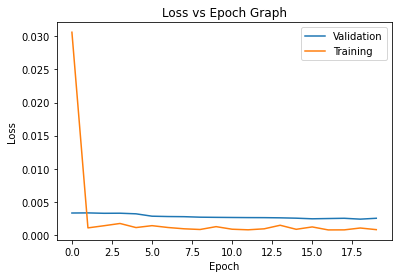

In [ ]:
import matplotlib.pyplot as plt

tr_loss = stat['tr_loss']
val_loss = stat['val_loss']
plt.plot(val_loss, label='Validation')
plt.plot(tr_loss, label='Training')
plt.legend()
plt.title('Loss vs Epoch Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()